In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime


hypotheses = pd.read_csv('hypotheses_us.csv' , sep=';')
orders= pd.read_csv('orders_us.csv')
visits = pd.read_csv('visits_us.csv')

# Realizamos limpieza y preparamos datos para su analisis
orders.columns = [c.strip().lower() for c in orders.columns]
visits.columns = [c.strip().lower() for c in visits.columns]
orders = orders.rename(columns={'transactionid':'transaction_id','visitorid':'visitor_id'})
if 'date' in orders.columns:
    orders['date'] = pd.to_datetime(orders['date'])
if 'date' in visits.columns:
    visits['date'] = pd.to_datetime(visits['date'])

#Limpiamos duplicados en ambos grupos
duplicados = orders.groupby('visitor_id')['group'].nunique()
visitantes_ambos = duplicados[duplicados > 1].index
orders = orders[~orders['visitor_id'].isin(visitantes_ambos)].copy()

orders.info()
print('\nPrimeras filas orders:')
display(orders.head())
visits.info()
print('\nPrimeras filas visits:')
display(visits.head())

<class 'pandas.core.frame.DataFrame'>
Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1016 non-null   int64         
 1   visitor_id      1016 non-null   int64         
 2   date            1016 non-null   datetime64[ns]
 3   revenue         1016 non-null   float64       
 4   group           1016 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 47.6+ KB

Primeras filas orders:


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB

Primeras filas visits:


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


# Parte 1

In [3]:
#ICE = (Impacto * Confianza) / Esfuerzo
#RICE = (Alcance * Impacto * Confianza) / Esfuerzo
hypotheses['ICE'] = (hypotheses['Impact']*hypotheses['Confidence'])/hypotheses['Effort']
hypotheses['RICE'] = (hypotheses['Reach']*hypotheses['Impact']*hypotheses['Confidence'])/hypotheses['Effort']

hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort,ICE,RICE
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333,40.0
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000,4.0
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000,56.0
3,Change the category structure. This will incre...,8,3,3,8,1.125000,9.0
4,Change the background color on the main page. ...,3,1,1,1,1.000000,3.0
5,Add a customer review page. This will increase...,3,2,2,3,1.333333,4.0
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000,40.0
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000,112.0
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000,16.2


In [4]:
# Comparamos los rankings ICE y RICE
comparison = hypotheses[['Hypothesis', 'ICE', 'RICE']].copy()

# 1. Crear la columna de Ranking ICE (posición)
comparison['ICE_Rank'] = comparison['ICE'].rank(method='first', ascending=False)
# 2. Crear la columna de Ranking RICE (posición)
comparison['RICE_Rank'] = comparison['RICE'].rank(method='first', ascending=False)

# 3. Crear una columna de Diferencia de Rank para ver el cambio de posición
comparison['Rank_Change'] = comparison['ICE_Rank'] - comparison['RICE_Rank']

# 4. Mostrar la tabla ordenada por el ranking RICE final
comparison = comparison.sort_values(by='RICE_Rank', ascending=True)

comparison 

,Hypothesis,ICE,RICE,ICE_Rank,RICE_Rank,Rank_Change
7,Add a subscription form to all the main pages....,11.200000,112.0,3.0,1.0,2.0
2,Add product recommendation blocks to the store...,7.000000,56.0,5.0,2.0,3.0
0,Add two new channels for attracting traffic. T...,13.333333,40.0,2.0,3.0,-1.0
6,Show banners with current offers and sales on ...,8.000000,40.0,4.0,4.0,0.0
8,Launch a promotion that gives users discounts ...,16.200000,16.2,1.0,5.0,-4.0
3,Change the category structure. This will incre...,1.125000,9.0,8.0,6.0,2.0
1,Launch your own delivery service. This will sh...,2.000000,4.0,6.0,7.0,-1.0
5,Add a customer review page. This will increase...,1.333333,4.0,7.0,8.0,-1.0
4,Change the background color on the main page. ...,1.000000,3.0,9.0,9.0,0.0


In [5]:
hypotheses.iloc[7,0]

'Add a subscription form to all the main pages. This will help you compile a mailing list'

## Análisis de  hipótesis

El Factor Decisivo es el Alcance (Reach): El cambio más significativo es que las hipótesis con un Reach alto (7 y 2) subieron drásticamente, mientras que la hipótesis con el mejor ICE (8), pero el Reach más bajo (1), cayó fuera del top 4.

***Hipótesis 7 (Suscripción):*** Se convierte en la prioridad número uno en RICE porque tiene el máximo alcance (10), lo que implica que el esfuerzo se aplicará a la mayor base de usuarios posible.

***La Hipótesis 8 ("Lanzar una campaña de promoción de cumpleaños"):*** Es la número 1 en ICE porque es una idea de alto impacto. Sin embargo, su alcance es mínimo (solo afecta a los usuarios en su cumpleaños). El valor total generado para el negocio es limitado.

**Conclusiones sobre la Priorización de Hipótesis** 

Para la mayoría de las empresas, el objetivo es el crecimiento y la optimización a gran escala, la Hipótesis 7 se alinea perfectamente con este objetivo, ya que busca captar a la mayor cantidad de usuarios posible para futuras comunicaciones y marketing, lo que tiene un potencial de ingresos a largo plazo. aunque la Hipótesis 8 es una "buena idea", la Hipótesis 7 es una inversión estratégica más inteligente porque aprovecha toda tu base de usuarios para generar valor.
 
 

# Parte 2

## A. Análisis Acumulado y Gráfico (Pasos 1 a 4)
El objetivo de estos pasos es visualizar la dinámica del test a lo largo del tiempo y detectar si los resultados se han estabilizado o si todavía hay anomalías que distorsionan las curvas.

### 1. Ingreso acumulado

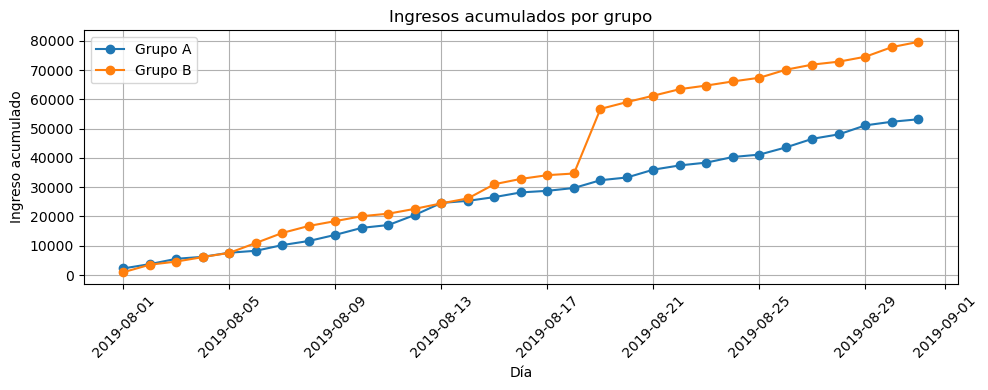

,date,group,revenue,cum_revenue
0,2019-08-01,A,2266.6,2266.6
1,2019-08-01,B,967.2,967.2
2,2019-08-02,A,1468.3,3734.9
3,2019-08-02,B,2568.1,3535.3
4,2019-08-03,A,1815.2,5550.1


In [6]:
# Ingresos acumulados por grupo
revenue_daily = orders.groupby(['date','group'], as_index=False).agg({'revenue':'sum'}).sort_values('date').drop_duplicates()
revenue_daily['cum_revenue'] = revenue_daily.groupby('group')['revenue'].cumsum()

# Visualización del ingreso acumulado por grupo
plt.figure(figsize=(10,4))
for g, dfg in revenue_daily.groupby('group'):
    plt.plot(dfg['date'], dfg['cum_revenue'], marker='o', label=f'Grupo {g}')
plt.xlabel('Día'); plt.ylabel('Ingreso acumulado'); plt.title('Ingresos acumulados por grupo'); plt.legend(); plt.grid(True)
plt.xticks(rotation=45); plt.tight_layout()
plt.show()

revenue_daily.head()

#### Análisis Ingreso acumulado

**Superioridad del Grupo B:** La línea de ingresos del Grupo B se mantiene consistentemente por encima de la del Grupo A, indicando un mejor desempeño en la generación de ingresos.

**Presencia de una Anomalía:** Alrededor del 18 de agosto de 2019, se registra un pico pronunciado en los ingresos del Grupo B. Este salto repentino no es característico de un crecimiento orgánico y apunta a la existencia de valores atípicos, como pedidos de gran valor.

**Interpretación con Precaución:** El pico infla significativamente los ingresos totales del Grupo B. Por lo tanto, si bien este grupo es el de mayor rendimiento, la diferencia con el Grupo A podría ser menor una vez excluidos estos valores atípicos.

En resumen, el gráfico indica que el Grupo B es el ganador en términos de ingresos totales, pero nos alerta sobre la posible presencia de pedidos anómalos que podrían estar distorsionando el resultado.


### 2. Tamaño de pedido promedio (AOV) acumulado

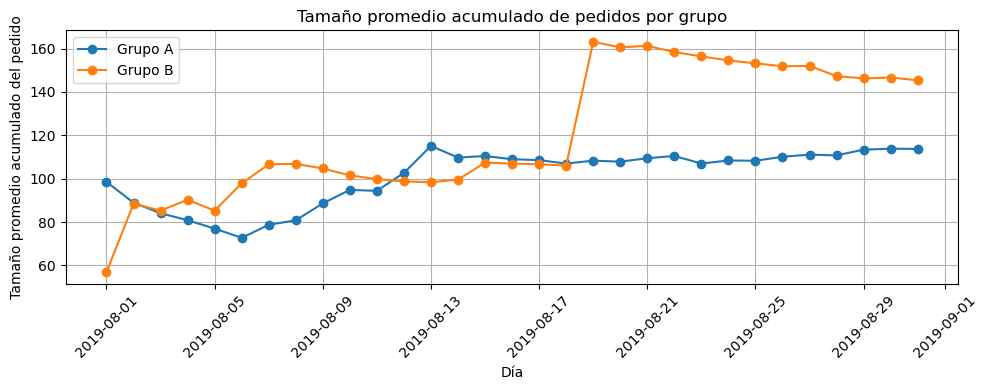

,date,group,revenue,orders,cum_orders,cum_revenue,cum_avg_order_size
0,2019-08-01,A,2266.6,23,23,2266.6,98.547826
1,2019-08-01,B,967.2,17,17,967.2,56.894118
2,2019-08-02,A,1468.3,19,42,3734.9,88.926190
3,2019-08-02,B,2568.1,23,40,3535.3,88.382500
4,2019-08-03,A,1815.2,24,66,5550.1,84.092424


In [7]:
# Tamaño de pedido promedio por grupo
orders_daily = orders.groupby(['date','group'], as_index=False).agg({'revenue':'sum','transaction_id':'count'}).rename(columns={'transaction_id':'orders'})
orders_daily['cum_orders'] = orders_daily.groupby('group')['orders'].cumsum()
orders_daily['cum_revenue'] = orders_daily.groupby('group')['revenue'].cumsum()
orders_daily['cum_avg_order_size'] = orders_daily['cum_revenue'] / orders_daily['cum_orders']

# Visualización de pedido promedio acumulado
plt.figure(figsize=(10,4))
for g, dfg in orders_daily.groupby('group'):
    plt.plot(dfg['date'], dfg['cum_avg_order_size'], marker='o', label=f'Grupo {g}')
plt.xlabel('Día'); plt.ylabel('Tamaño promedio acumulado del pedido'); plt.title('Tamaño promedio acumulado de pedidos por grupo'); plt.legend(); plt.grid(True)
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

orders_daily.head()

#### Análisis Tamaño promedio acumulado de pedidos 

**Confirmación de Anomalía:** 
El pico pronunciado del Grupo B el 18 de agosto confirma que el aumento previo en ingresos se debió a pedidos de valor excepcional, no a una mejora sostenida en el comportamiento de compra.

**Estabilidad vs. Volatilidad:**

***Grupo A:*** Muestra un crecimiento gradual y estable, con tendencia a estabilizarse.

***Grupo B:*** Presenta alta volatilidad, con un pico extremo que distorsiona sus resultados.

**Influencia de Valores Atípicos:** 
Sin el pico, el tamaño promedio de pedido de ambos grupos sería similar. El descenso posterior del Grupo B refuerza que su aparente ventaja está sesgada por valores atípicos.

**Conclusión:**  
El aparente liderazgo del Grupo B en el tamaño promedio del pedido es engañoso y se debe a valores atípicos. El comportamiento de compra del Grupo A es más estable y predecible. Para tomar una decisión justa, es indispensable analizar los datos sin el efecto de estos pedidos anómalos.

### 3. Diferencia relativa en el AOV acumulado (A vs B)

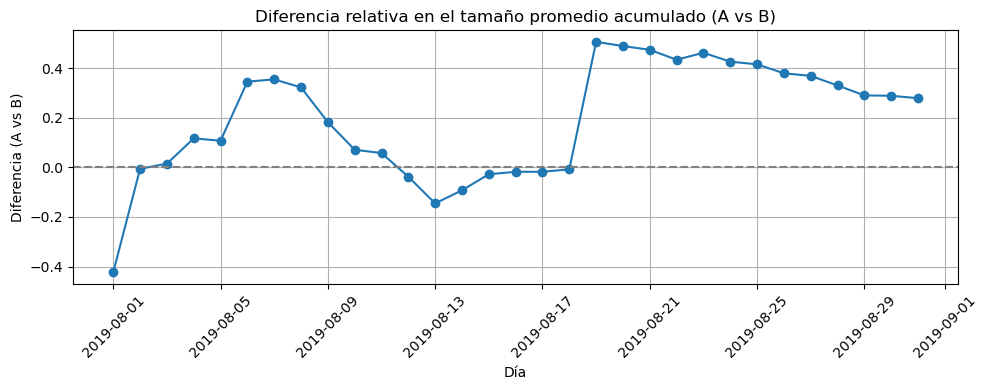

group,date,A,B,rel_diff_A_vs_B
0,2019-08-01,98.547826,56.894118,-0.422675
1,2019-08-02,88.926190,88.382500,-0.006114
2,2019-08-03,84.092424,85.312963,0.014514
3,2019-08-04,80.851948,90.272059,0.116511
4,2019-08-05,77.006061,85.256180,0.107136


In [8]:
# Diferencia relativa en el tamaño promedio del pedido entre grupos
pivot_avg = orders_daily.pivot_table(index='date', columns='group', values='cum_avg_order_size').reset_index()

# Calculamos la diferencia relativa solo si ambos grupos están presentes
if 'A' in pivot_avg.columns and 'B' in pivot_avg.columns:
    pivot_avg['rel_diff_A_vs_B'] = (pivot_avg['B'] / pivot_avg['A']) - 1
    plt.figure(figsize=(10,4))
    plt.plot(pivot_avg['date'], pivot_avg['rel_diff_A_vs_B'], marker='o')
    plt.axhline(0, linestyle='--', color='gray')
    plt.xlabel('Día'); plt.ylabel('Diferencia (A vs B)'); plt.title('Diferencia relativa en el tamaño promedio acumulado (A vs B)'); plt.xticks(rotation=45); plt.grid(True); plt.tight_layout(); plt.show()
    display(pivot_avg[['date','A','B','rel_diff_A_vs_B']].head())
else:
    print('No se encontraron ambos grupos A y B en los datos de órdenes. Columnas:', pivot_avg.columns.tolist())

#### Análisis diferencia relativa en el tamaño AOV acumulado


**Volatilidad Extrema:** 
La diferencia entre grupos es altamente inestable, cruzando repetidamente la línea cero. Esto indica que no hay un líder claro o consistente en el tamaño promedio de pedido durante la mayor parte de la prueba.

**Dominio de un Valor Atípico:** 
El pico masivo del 18 de agosto domina por completo la métrica. Este evento único distorsiona la comparación, creando la apariencia repentina de una superioridad abrumadora del Grupo B que no es representativa.

**Falta de Estabilización:** 
La métrica no converge hacia un valor estable, lo que confirma que los resultados están impulsados por anomalías y no por un comportamiento de usuario consistente.


**Conclusión:**  
Este gráfico demuestra de manera contundente que la métrica de tamaño promedio de pedido, en su forma actual, es poco fiable para la toma de decisiones. La influencia desproporcionada de los valores atípicos sesga los resultados, haciendo imperativo un análisis con datos filtrados y pruebas de significancia estadística antes de extraer cualquier conclusión válida.

### 4. Tasa de conversión (CR) diaria

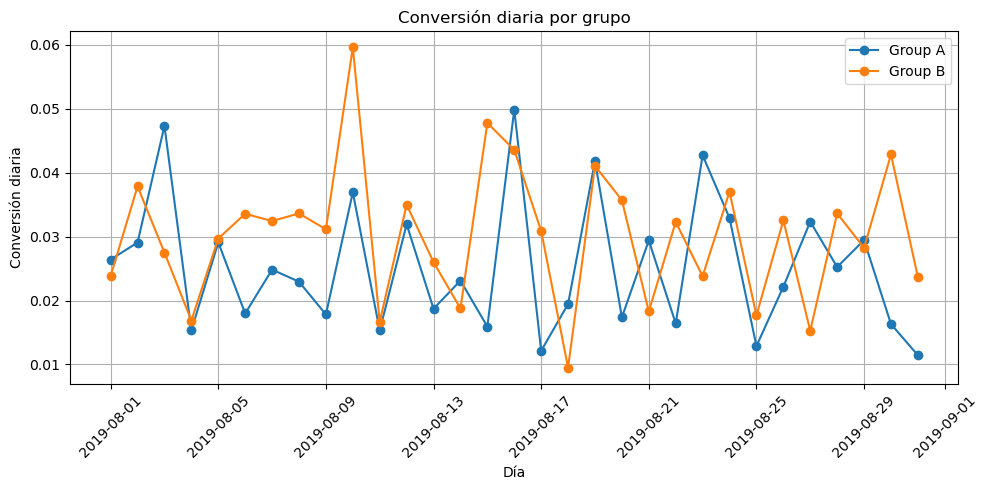

,date,group,visits,orders_users,conversion
0,2019-08-01,A,719,19,0.026426
1,2019-08-01,B,713,17,0.023843
2,2019-08-02,A,619,18,0.029079
3,2019-08-02,B,581,22,0.037866
4,2019-08-03,A,507,24,0.047337


In [9]:
#tasa de conversión diaria por grupo
visits_daily = visits.groupby(['date','group'], as_index=False).agg({'visits':'sum'})
orders_users_daily = orders.groupby(['date','group'], as_index=False).agg({'visitor_id':lambda x: x.nunique()}).rename(columns={'visitor_id':'orders_users'})
daily = visits_daily.merge(orders_users_daily, on=['date','group'], how='left').fillna(0)
daily['conversion'] = daily['orders_users'] / daily['visits']

# Visualización de la tasa de conversion diaria por grupo
plt.figure(figsize=(10,5))
for g, dfg in daily.groupby('group'):
    plt.plot(dfg['date'], dfg['conversion'], marker='o', label=f'Group {g}')
plt.xlabel('Día'); plt.ylabel('Conversión diaria'); plt.title('Conversión diaria por grupo'); plt.legend(); plt.grid(True); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

daily.head()

#### Análisis Tasa de conversión (CR) diaria 

**Alta Volatilidad:**
La conversión diaria muestra fluctuaciones pronunciadas en ambos grupos, un comportamiento esperado en métricas granulares debido a variaciones naturales en el tráfico o campañas puntuales.

**Sin Liderazgo Definido:**
No se identifica un grupo consistentemente superior:

*El Grupo A registra picos notables en ciertos días.*

*El Grupo B también presenta picos ocasionales, incluso superando al Grupo A en algunas fechas (ej. ~9 de agosto).*

El constante cruce de las líneas refleja que la ventaja relativa cambia frecuentemente.

**Tendencia Incierta:**
Hacia la segunda mitad del período, el Grupo B podría mostrar un rendimiento ligeramente más estable o superior, mientras el Grupo A presenta caídas más marcadas. Sin embargo, esta observación es preliminar debido al alto nivel de ruido.

**Conclusión:**  
La extrema volatilidad hace imposible determinar un ganador basándose únicamente en datos diarios. Este gráfico refuerza la necesidad de utilizar:

1. Conversión Acumulada: Para suavizar el ruido y observar tendencias de largo plazo.

2. Pruebas de Significancia Estadística: Para validar si las diferencias observadas son consistentes y significativas.

## B. Detección de Anomalías (Outliers) (Pasos 5 a 8)
El objetivo de esta sección es cuantificar y definir los puntos de datos extremos que distorsionan las métricas acumuladas, preparándose para un análisis estadístico más limpio.

### 5. Gráfico de dispersión del número de pedidos por usuario

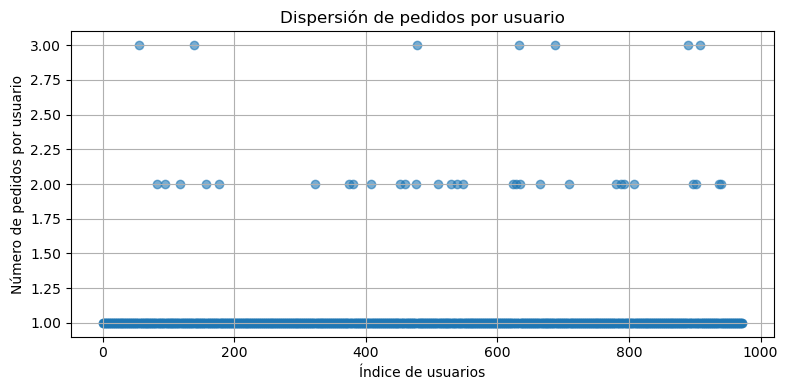

,visitor_id,orders_count
0,5114589,1
1,6958315,1
2,11685486,1
3,39475350,1
4,47206413,1


In [10]:
# Número de pedidos por usuario
orders_per_user = orders.groupby('visitor_id', as_index=False).agg({'transaction_id':'count'}).rename(columns={'transaction_id':'orders_count'})

# Visualización del número de pedidos por usuario
plt.figure(figsize=(8,4))
plt.scatter(range(len(orders_per_user)), orders_per_user['orders_count'], alpha=0.6)
plt.xlabel('Índice de usuarios'); plt.ylabel('Número de pedidos por usuario'); plt.title('Dispersión de pedidos por usuario'); plt.grid(True); plt.tight_layout(); plt.show()
orders_per_user.head()

#### Análisis Gráfico de Dispersión
**Comportamiento Mayoritario:**
La gran mayoría de los usuarios se concentra en un solo pedido, lo que define el perfil típico del cliente.

**Clientela Recurrente Limitada:**
Un grupo significativamente menor realiza entre 2 y 3 pedidos, representando a los clientes recurrentes, que constituyen una fracción mínima del total.

**Ausencia de Comportamientos Extremos:**
No se observan usuarios con volúmenes de compra elevados (superiores a 3 pedidos), lo que confirma que el comportamiento de compra se mantiene en un rango muy bajo y acotado.

**Conclusión:**  
El patrón de compra está dominado por transacciones únicas. Los clientes recurrentes son una minoría, lo que indica que la estrategia de negocio debería priorizar la captación de nuevos clientes o diseñar iniciativas específicas para fomentar la recurrencia en esta base reducida.




### 6. Percentiles 95 y 99 de pedidos

In [11]:
# Cálculamos percentiles
p95_orders_user = np.percentile(orders_per_user['orders_count'], 95)
p99_orders_user = np.percentile(orders_per_user['orders_count'], 99)
print('Percentiles de pedidos por usuario:')
print(f'Percentil 95: {p95_orders_user}, Percentil 99: {p99_orders_user}')

Percentiles de pedidos por usuario:
Percentil 95: 1.0, Percentil 99: 2.0


#### Análisis de percentiles

***El 95% de los usuarios realizó 1 pedido o menos,*** esto confirma que la gran mayoría de los clientes son compradores de una sola vez.

***Solo el 1% de los usuarios supera los 2 pedidos***, lo que los convierte en casos excepcionales dentro de la base de clientes.

**Conclusión:**  
 Basado en estos percentiles, podemos definir un umbral para identificar a los usuarios con un comportamiento de compra anómalo. Un usuario que realiza más de 2 pedidos es una clara excepción. Por lo tanto, para limpiar los datos y evitar que estos casos extremos distorsionen los resultados, filtraremos y excluiremos a todos los usuarios que hayan realizado más de 2 pedidos.

### 7. Gráfico de dispersión de precios de pedidos

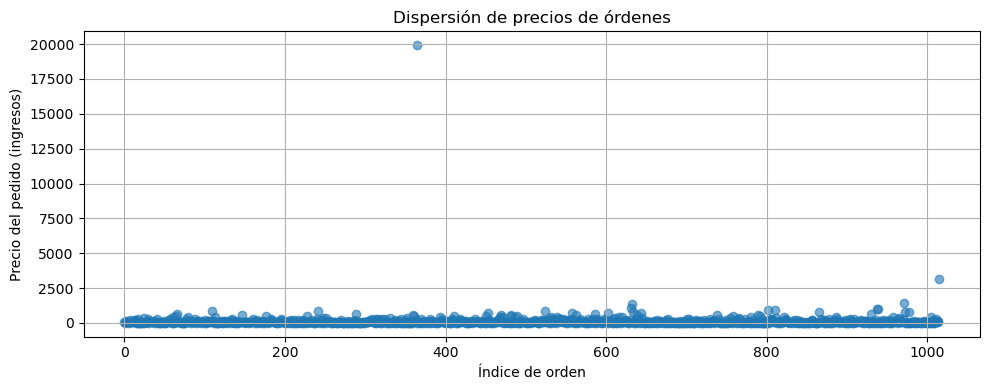

,transaction_id,visitor_id,revenue,group
0,590470918,1920142716,19920.4,B
1,3936777065,2108080724,3120.1,B
2,666610489,1307669133,1425.8,A
3,3668308183,888512513,1335.6,B
4,3603576309,4133034833,1050.0,A


In [12]:
# Visualización de los precios de los pedidos
plt.figure(figsize=(10,4))
plt.scatter(range(len(orders)), orders['revenue'].fillna(0), alpha=0.6)
plt.xlabel('Índice de orden'); plt.ylabel('Precio del pedido (ingresos)'); plt.title('Dispersión de precios de órdenes'); plt.grid(True); plt.tight_layout(); plt.show()
# Mostramos las órdenes con mayores ingresos
orders[['transaction_id','visitor_id','revenue','group']].sort_values('revenue', ascending=False).reset_index(drop=True).head()

#### Análisis de dispersión de precios de pedidos

**Concentración en Valores Bajos:**
La mayoría de los pedidos se agrupan en la zona inferior (valores inferiores a 2,500), lo que refleja el comportamiento de compra típico de la base de clientes.

**Valores Atípicos Extremos:**
Se identifica un pedido excepcional con un valor cercano a 20,000, responsable de los picos observados en las métricas de ingresos y promedio de pedido. Se detecta también otro valor atípico superior a 2,500.

**Impacto Distorsionador:**
El pedido de $20,000 ejerce una influencia desproporcionada en los resultados del Grupo B, inflando artificialmente sus métricas y creando una percepción errónea sobre su rendimiento real.

**Conclusión:**  
El gráfico confirma visualmente y sin lugar a dudas la existencia de al menos un pedido con un valor anómalamente alto que está sesgando todo el análisis. Para poder realizar una comparación justa entre los grupos A y B, es indispensable filtrar estos valores atípicos.

### 8. Percentiles 95 y 99 de precios

In [13]:
# Cálculamos percentiles
p95_price = np.percentile(orders['revenue'].dropna(), 95)
p99_price = np.percentile(orders['revenue'].dropna(), 99)
print('Percentiles de pedidos por usuario:')
print(f'Percentil 95: {p95_price}, Percentil 99: {p99_price}')

Percentiles de pedidos por usuario:
Percentil 95: 414.275, Percentil 99: 830.3


#### Análisis de percentiles

**El 95% de los pedidos tienen un valor de 414.28 o menos**, definiendo el rango de transacciones típicas.

**Solo el 1% de los pedidos supera los 830.30**, marcando el límite superior del comportamiento de compra normal.


**Conclusión:**  
Estos percentiles nos proporcionan un umbral claro y objetivo para definir qué es un valor atípico. El pedido de casi 20,000 que vimos en el gráfico anterior está muy por encima del percentil 99, confirmando que es un caso extremo que debe ser excluido.



## C. Pruebas de Significancia Estadística (Pasos 9 a 12)
El objetivo es determinar si las diferencias observadas en las métricas (CR y AOV) son estadísticamente significativas o si se deben al azar.

### 9. Significancia CR (Datos Brutos)

Tabla de Conversión (CR) con Datos Crudos:


,group,visits,orders_users,conversion
0,A,18736,445,0.023751
1,B,18916,528,0.027913


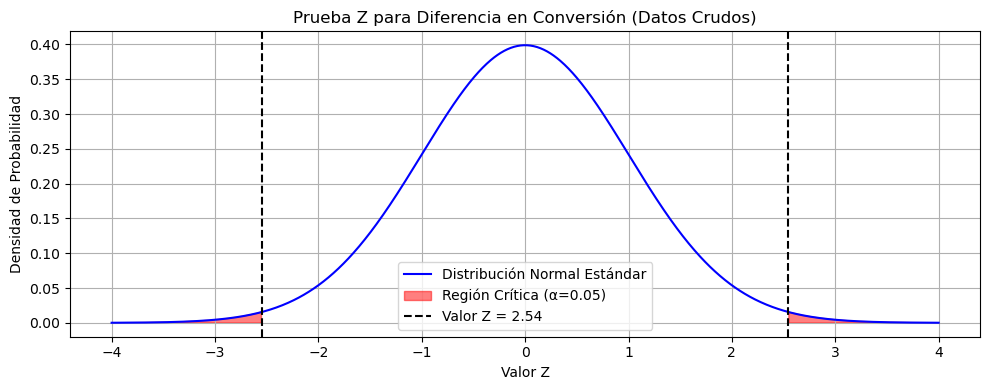


Resultados de la Prueba Z para Conversión (Datos Crudos):

P-value (CR raw): 0.0109
Valor Z (CR raw): 2.5449
Tasa de Conversión Grupo A: 0.0238
Tasa de Conversión Grupo B: 0.0279
Conclusión: ¡Diferencia en Conversión es estadísticamente significativa! (p < 0.05)


In [14]:
# CÁLCULO DE CONVERSIÓN Y PRUEBA Z (DATOS CRUDOS)

# 1. CALCULA LA CONVERSIÓN POR GRUPO
# Total de visitas por grupo (N para la prueba Z)
visits_total = visits.groupby('group', as_index=False).agg({'visits':'sum'})
# Total de usuarios únicos con al menos una orden (Éxitos para la prueba Z)
orders_users_total = orders.groupby('group', as_index=False).agg({'visitor_id':lambda x: x.nunique()}).rename(columns={'visitor_id':'orders_users'})

# Combina, calcula la Tasa de Conversión (CR) e imprime el resultado de la tabla
conv_total = visits_total.merge(orders_users_total, on='group', how='left').fillna(0)
conv_total['conversion'] = conv_total['orders_users'] / conv_total['visits']
print('Tabla de Conversión (CR) con Datos Crudos:')
display(conv_total)

# 2. FUNCIÓN PARA LA PRUEBA Z DE PROPORCIONES
# Función para comparar la CR entre dos grupos.
def proportions_z_test(success_a, n_a, success_b, n_b):
    p1 = success_a / n_a
    p2 = success_b / n_b
    p_pool = (success_a + success_b) / (n_a + n_b)
    se = np.sqrt(p_pool * (1 - p_pool) * (1/n_a + 1/n_b))
    z = (p2 - p1) / se
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    return z, p_value, p1, p2

# 3. EJECUCIÓN DE LA PRUEBA Z
if set(conv_total['group'].unique()) >= set(['A','B']):
    # Prepara datos para la prueba Z con datos crudos
    rowA = conv_total[conv_total['group']=='A'].iloc[0]
    rowB = conv_total[conv_total['group']=='B'].iloc[0]
    
    # Ejecuta la prueba Z
    z_raw, pval_conv_raw, pA_raw, pB_raw = proportions_z_test(rowA['orders_users'], rowA['visits'], rowB['orders_users'], rowB['visits'])

    # Grafica de la distribución normal estándar con el valor z
    x = np.linspace(-4, 4, 1000)
    y = stats.norm.pdf(x)
    plt.figure(figsize=(10,4))
    plt.plot(x, y, label='Distribución Normal Estándar', color='blue')
    plt.fill_between(x, y, where=(x <= -abs(z_raw)) | (x >= abs(z_raw)), color='red', alpha=0.5, label='Región Crítica (α=0.05)')
    plt.axvline(z_raw, color='black', linestyle='--', label=f'Valor Z = {z_raw:.2f}')
    plt.axvline(-z_raw, color='black', linestyle='--')
    plt.title('Prueba Z para Diferencia en Conversión (Datos Crudos)')
    plt.xlabel('Valor Z'); plt.ylabel('Densidad de Probabilidad'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
    
    # Imprime los resultados clave de la prueba Z
    print('\nResultados de la Prueba Z para Conversión (Datos Crudos):')
    print(f'\nP-value (CR raw): {pval_conv_raw:.4f}')
    print(f'Valor Z (CR raw): {z_raw:.4f}')
    print(f'Tasa de Conversión Grupo A: {pA_raw:.4f}')
    print(f'Tasa de Conversión Grupo B: {pB_raw:.4f}')
    
    # Evaluación de significancia
    alpha = 0.05 # Se asume el nivel de significancia
    if pval_conv_raw < alpha:
        print('Conclusión: ¡Diferencia en Conversión es estadísticamente significativa! (p < 0.05)')
    else:
        print('Conclusión: La diferencia en Conversión NO es estadísticamente significativa (p >= 0.05)')
        
else:
    print('No hay ambos grupos A y B para el test de conversión (raw).')

#### Análisis de los Resultados Datos Brutos

Los resultados nos demuestran que El Grupo B presenta una superioridad estadísticamente significativa en tasa de conversión

**Superioridad del Grupo B:** El Grupo B mantiene su ventaja en la tasa de conversión, alcanzando un 2.79% frente al 2.38% del Grupo A. Esto representa una mejora relativa del 17% a favor del Grupo B.

**Significancia Estadística Confirmada:** El p-value es de 0.0109, que es un valor bajo y se encuentra firmemente por debajo del umbral de significancia de 0.05. Esto nos permite rechazar la hipótesis de que no hay diferencia entre los grupos.

**Conclusión:**  
La prueba confirma con un alto grado de confianza estadística que el Grupo B es genuinamente superior al Grupo A en términos de tasa de conversión.

### 10. Significancia AOV (Datos Brutos)

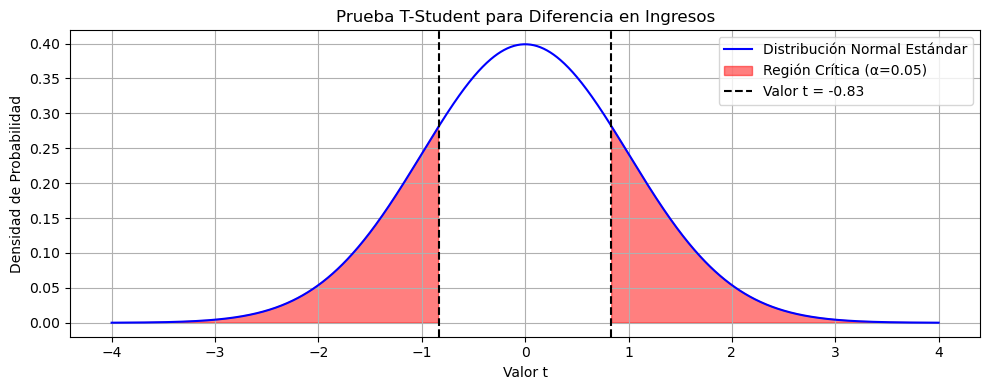


Resultados de las Pruebas de Ingresos:
Ingreso Promedio Grupo A: $113.70
Ingreso Promedio Grupo B: $145.35

Resultados de Prueba Mann-Whitney U (p-value):
pval_mw = 0.8622329690015668

Resultados de Prueba T-Student (p-value):
pval_t = 0.4043438730780975

Análisis de Significancia (basado en Mann-Whitney):
Conclusión: La diferencia en Ingresos NO es estadísticamente significativa (p >= 0.05)


In [15]:
# VALOR PROMEDIO DE PEDIDOS Y PRUEBAS ESTADÍSTICAS

# 1. PREPARACIÓN DE DATOS DE INGRESO
# Filtra las órdenes para los grupos A y B
orders_AB = orders[orders['group'].isin(['A','B'])].copy()
# Extrae los ingresos (revenue) de cada grupo (A y B)
orders_A = orders_AB[orders_AB['group']=='A']['revenue'].dropna()
orders_B = orders_AB[orders_AB['group']=='B']['revenue'].dropna()

# 2. EJECUCIÓN DE PRUEBAS
if len(orders_A)>0 and len(orders_B)>0:
    # Mann-Whitney U test 
    u_stat, pval_mw = stats.mannwhitneyu(orders_A, orders_B, alternative='two-sided')
    # T-test 
    t_stat, pval_t = stats.ttest_ind(orders_A, orders_B, equal_var=False, nan_policy='omit')

    #Grafica de la distribución normal estándar con el valor z
    x = np.linspace(-4, 4, 1000)
    y = stats.norm.pdf(x)
    plt.figure(figsize=(10,4))
    plt.plot(x, y, label='Distribución Normal Estándar', color='blue')
    plt.fill_between(x, y, where=(x <= -abs(t_stat)) | (x >= abs(t_stat)), color='red', alpha=0.5, label='Región Crítica (α=0.05)')
    plt.axvline(t_stat, color='black', linestyle='--', label=f'Valor t = {t_stat:.2f}')
    plt.axvline(-t_stat, color='black', linestyle='--')
    plt.title('Prueba T-Student para Diferencia en Ingresos')
    plt.xlabel('Valor t'); plt.ylabel('Densidad de Probabilidad'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
    
    # Imprime los resultados
    print('\nResultados de las Pruebas de Ingresos:')
    print(f'Ingreso Promedio Grupo A: ${orders_A.mean():.2f}')
    print(f'Ingreso Promedio Grupo B: ${orders_B.mean():.2f}')
    
    print('\nResultados de Prueba Mann-Whitney U (p-value):')
    print('pval_mw =', pval_mw)
    
    print('\nResultados de Prueba T-Student (p-value):')
    print('pval_t =', pval_t)
    
    # Evaluación de significancia (se usa Mann-Whitney por ser más robusto a outliers)
    alpha = 0.05 
    print('\nAnálisis de Significancia (basado en Mann-Whitney):')
    if pval_mw < alpha:
        print('Conclusión: ¡Diferencia en Ingresos es estadísticamente significativa! (p < 0.05)')
    else:
        print('Conclusión: La diferencia en Ingresos NO es estadísticamente significativa (p >= 0.05)')
        
else:
    print('No hay suficientes órdenes en A o B para comparar (raw).')

#### Análisis de los Resultados Datos Brutos

Aunque el valor promedio de pedido (AOV) del Grupo B ($145.35) es nominalmente superior al del Grupo A ($113.70), esta diferencia carece de significancia estadística.

La prueba de Mann-Whitney U resulta en un p-value de 0.86. Este valor, muy superior al umbral de 0.05, confirma que la aparente ventaja del Grupo B es un artefacto causado por pedidos anómalos, no una diferencia real en el comportamiento de compra.

**Conclusión:**  
No existe evidencia estadística para declarar un ganador en términos de valor promedio de pedido (AOV) basándose en los datos brutos.

### 11. Significancia CR (Datos Filtrados)

In [16]:
# Filtramos los datos para eliminar usuarios anómalos
users_many_orders_index = orders.groupby('visitor_id')['transaction_id'].count()
users_many_orders_index = users_many_orders_index[users_many_orders_index > p99_orders_user].index
users_high_revenue = orders[orders['revenue'] > p99_price]['visitor_id']

abnormal_users = pd.concat([users_high_revenue, pd.Series(users_many_orders_index)], axis=0).drop_duplicates()

# CREAR DATAFRAME DE ÓRDENES FILTRADAS
orders_filtered = orders[~orders['visitor_id'].isin(abnormal_users)]

print(f"Número de usuarios anómalos filtrados: {len(abnormal_users)}")
print(f"Total de órdenes antes de filtrar: {len(orders)}")
print(f"Total de órdenes después de filtrar: {len(orders_filtered)}")

Número de usuarios anómalos filtrados: 16
Total de órdenes antes de filtrar: 1016
Total de órdenes después de filtrar: 986



Tabla de Conversión (CR) con Datos Filtrados:


,group,visits,orders_users,conversion
0,A,18736,435,0.023217
1,B,18916,522,0.027596


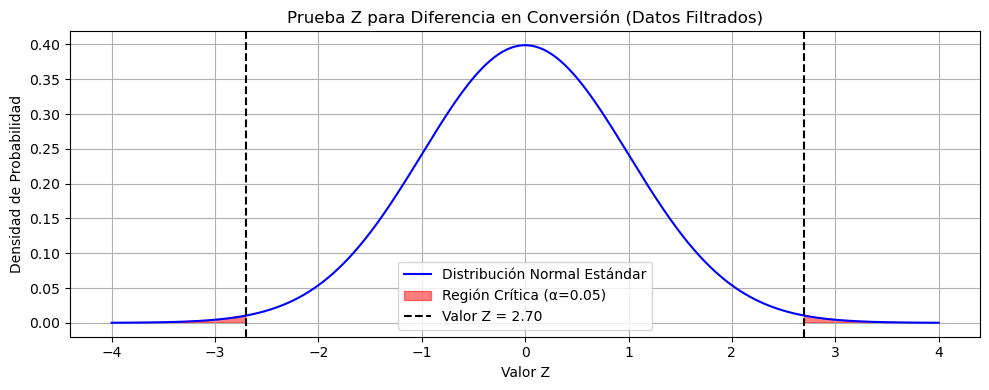


Resultados de la Prueba Z para Conversión (Datos Filtrados):

P-value (CR filtrada): 0.0070
Valor Z (CR filtrada): 2.6990
Tasa de Conversión Grupo A: 0.0232
Tasa de Conversión Grupo B: 0.0276
Conclusión CR: ¡La diferencia es estadísticamente significativa!


In [17]:
# CALCULAR SIGNIFICANCIA DE CR CON DATOS FILTRADOS
# Éxitos (compradores únicos) del dataframe de órdenes filtradas
orders_users_total_filtered = orders_filtered.groupby('group', as_index=False).agg({'visitor_id':'nunique'}).rename(columns={'visitor_id':'orders_users'})
# Total de visitas (del dataframe original, ya que no se puede filtrar)
visits_total = visits.groupby('group', as_index=False).agg({'visits':'sum'})

# Combinar y calcular CR
conv_total_filtered = visits_total.merge(orders_users_total_filtered, on='group', how='left').fillna(0)
conv_total_filtered['conversion'] = conv_total_filtered['orders_users'] / conv_total_filtered['visits']

print('\nTabla de Conversión (CR) con Datos Filtrados:')
display(conv_total_filtered)

# FUNCIÓN PARA LA PRUEBA Z DE PROPORCIONES
# Función para comparar la CR entre dos grupos.
def proportions_z_test(success_a, n_a, success_b, n_b):
    p1 = success_a / n_a
    p2 = success_b / n_b
    p_pool = (success_a + success_b) / (n_a + n_b)
    se = np.sqrt(p_pool * (1 - p_pool) * (1/n_a + 1/n_b))
    z = (p2 - p1) / se
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    return z, p_value, p1, p2


# Ejecutar la prueba Z
rowA_filtered = conv_total_filtered[conv_total_filtered['group']=='A'].iloc[0]
rowB_filtered = conv_total_filtered[conv_total_filtered['group']=='B'].iloc[0]
z_filt, pval_conv_filt, pA_filt, pB_filt = proportions_z_test(rowA_filtered['orders_users'], rowA_filtered['visits'], rowB_filtered['orders_users'], rowB_filtered['visits'])

# Grafica de la distribución normal estándar con el valor z
x = np.linspace(-4, 4, 1000)
y = stats.norm.pdf(x)
plt.figure(figsize=(10,4))
plt.plot(x, y, label='Distribución Normal Estándar', color='blue')
plt.fill_between(x, y, where=(x <= -abs(z_filt)) | (x >= abs(z_filt)), color='red', alpha=0.5, label='Región Crítica (α=0.05)')
plt.axvline(z_filt, color='black', linestyle='--', label=f'Valor Z = {z_filt:.2f}')
plt.axvline(-z_filt, color='black', linestyle='--')
plt.title('Prueba Z para Diferencia en Conversión (Datos Filtrados)')
plt.xlabel('Valor Z'); plt.ylabel('Densidad de Probabilidad'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# Imprime los resultados clave de la prueba Z
print('\nResultados de la Prueba Z para Conversión (Datos Filtrados):')
print(f'\nP-value (CR filtrada): {pval_conv_filt:.4f}')
print(f'Valor Z (CR filtrada): {z_filt:.4f}')
print(f'Tasa de Conversión Grupo A: {rowA_filtered["conversion"]:.4f}')
print(f'Tasa de Conversión Grupo B: {rowB_filtered["conversion"]:.4f}')
if pval_conv_filt < 0.05:
    print('Conclusión CR: ¡La diferencia es estadísticamente significativa!')
else:
    print('Conclusión CR: La diferencia NO es estadísticamente significativa.')

#### Análisis de los Resultados Datos Filtrados

El grupo B sigue mostrando una tasa de conversión más alta (2.76%) en comparación con el grupo A (2.32%). La diferencia relativa es de aproximadamente un 19% a favor del grupo B, contamos tambien con un valor **p** que es 0.0070. Este valor es significativamente menor que el nivel de alfa estándar (0.05).

**Conclusión:**  
Rechazamos la hipótesis nula. Existe una diferencia estadísticamente significativa en la tasa de conversión entre los grupos A y B, incluso después de eliminar los valores atípicos. El grupo B supera al grupo A en términos de conversión. El filtrado de datos no alteró la conclusión inicial, lo que refuerza la solidez de este hallazgo. En esta métrica clave, el Grupo B es el ganador indiscutible.




### 12. Significancia AOV (Datos Filtrados)

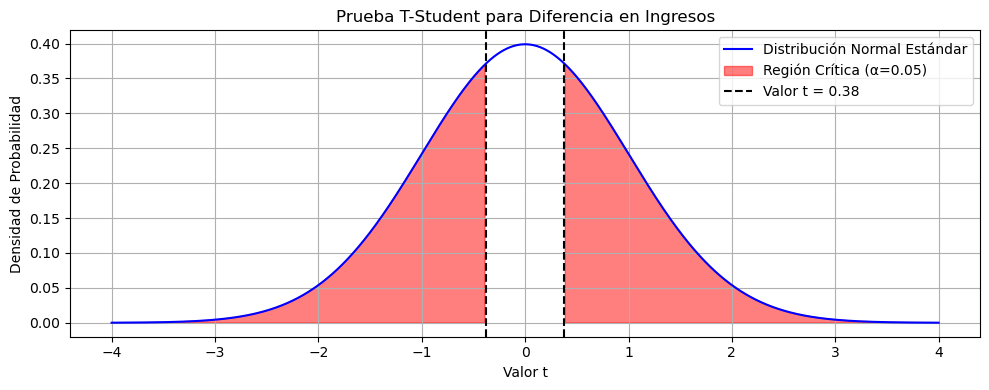


Resultados de las Pruebas de Ingresos:
Ingreso Promedio Grupo A: $102.90
Ingreso Promedio Grupo B: $99.61

Resultados de Prueba Mann-Whitney U (p-value):
pval_mw = 0.8220253140355853

Resultados de Prueba T-Student (p-value):
pval_t = 0.7035214166868313

Análisis de Significancia (basado en Mann-Whitney):
Conclusión: La diferencia en Ingresos NO es estadísticamente significativa (p >= 0.05)


In [18]:
# VALOR PROMEDIO DE PEDIDOS Y PRUEBAS ESTADÍSTICAS

# 1. PREPARACIÓN DE DATOS DE INGRESO
# Filtra las órdenes para los grupos A y B
orders_AB_filt = orders_filtered[orders_filtered['group'].isin(['A','B'])].copy()
# Extrae los ingresos (revenue) de cada grupo (A y B)
orders_A_filt = orders_AB_filt[orders_AB_filt['group']=='A']['revenue'].dropna()
orders_B_filt = orders_AB_filt[orders_AB_filt['group']=='B']['revenue'].dropna()

# 2. EJECUCIÓN DE PRUEBAS
if len(orders_A_filt)>0 and len(orders_B_filt)>0:
    # Mann-Whitney U test 
    u_stat, pval_mw_filt = stats.mannwhitneyu(orders_A_filt, orders_B_filt, alternative='two-sided')
    # T-test 
    t_stat, pval_t_flit = stats.ttest_ind(orders_A_filt, orders_B_filt, equal_var=False, nan_policy='omit')

    #Grafica de la distribución normal estándar con el valor z
    x = np.linspace(-4, 4, 1000)
    y = stats.norm.pdf(x)
    plt.figure(figsize=(10,4))
    plt.plot(x, y, label='Distribución Normal Estándar', color='blue')
    plt.fill_between(x, y, where=(x <= -abs(t_stat)) | (x >= abs(t_stat)), color='red', alpha=0.5, label='Región Crítica (α=0.05)')
    plt.axvline(t_stat, color='black', linestyle='--', label=f'Valor t = {t_stat:.2f}')
    plt.axvline(-t_stat, color='black', linestyle='--')
    plt.title('Prueba T-Student para Diferencia en Ingresos')
    plt.xlabel('Valor t'); plt.ylabel('Densidad de Probabilidad'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
    
    # Imprime los resultados
    print('\nResultados de las Pruebas de Ingresos:')
    print(f'Ingreso Promedio Grupo A: ${orders_A_filt.mean():.2f}')
    print(f'Ingreso Promedio Grupo B: ${orders_B_filt.mean():.2f}')
    
    print('\nResultados de Prueba Mann-Whitney U (p-value):')
    print('pval_mw =', pval_mw_filt)
    
    print('\nResultados de Prueba T-Student (p-value):')
    print('pval_t =', pval_t_flit)
    
    # Evaluación de significancia (se usa Mann-Whitney por ser más robusto a outliers)
    alpha = 0.05 
    print('\nAnálisis de Significancia (basado en Mann-Whitney):')
    if pval_mw_filt < alpha:
        print('Conclusión: ¡Diferencia en Ingresos es estadísticamente significativa! (p < 0.05)')
    else:
        print('Conclusión: La diferencia en Ingresos NO es estadísticamente significativa (p >= 0.05)')
        
else:
    print('No hay suficientes órdenes en A o B para comparar (raw).')

#### Análisis de los Resultados Datos Filtrados

Después de filtrar los valores atípicos, el ingreso promedio del Grupo A ($102.90) es ligeramente superior al del Grupo B ($99.61). Esto es interesante porque invierte lo que veíamos en los datos brutos, demostrando el gran efecto que tenían los pedidos anómalos.

**Valor p (Mann-Whitney)**: El valor p es 0.822. Este valor es muy alto, mucho mayor que nuestro nivel de significancia de 0.05.

**Conclusión:**  
No podemos rechazar la hipótesis nula. No hay una diferencia estadísticamente significativa en el valor promedio del pedido entre los grupos A y B. Aunque el promedio del Grupo A es un poco más alto, esta diferencia se debe al azar y no a un efecto real.

## 13. Decisión final basada en los resultados

In [19]:
# 1. Definición de umbral y variables
alpha = 0.05
decision = ''
reasons = []

# Calcular medias valor promedio (AOV) para la justificación
meanA_aov = orders_A.mean()
meanB_aov = orders_B.mean()

# 2. EVALUACIÓN DE CONVERSIÓN (CR)
if pval_conv_filt < alpha:
    if pB_filt > pA_filt:
        decision = 'Parar la prueba, considerar al Grupo B como líder.'
        reasons.append(f'CR: El Grupo B es SIGNIFICATIVAMENTE mejor (p={pval_conv_filt:.4f}).')
    else:
        decision = 'Parar la prueba, considerar al Grupo A como líder.'
        reasons.append(f'CR: El Grupo A es SIGNIFICATIVAMENTE mejor (p={pval_conv_filt:.4f}).')
else:
    reasons.append(f'CR: No hay diferencia significativa (p={pval_conv_filt:.4f}).')

# 3. EVALUACIÓN DE VALOR PROMEDIO DEL PEDIDO (AOV)
if pval_mw_filt < alpha:
    # AOV es significativo, lo cual puede contradecir o reforzar
    if decision.endswith('líder.') and (meanB_aov > meanA_aov if 'Grupo B' in decision else meanA_aov > meanB_aov):
        reasons.append(f'AOV: La diferencia es significativa, REFUERZA la decisión inicial (p={pval_mw_filt:.4f}).')
    else:
        # Conflicto CR vs AOV
        decision = 'Continuar la prueba. (Conflicto CR/AOV)'
        reasons.append(f'AOV: Hay diferencia significativa (p={pval_mw_filt:.4f}), CONFLICTO con la CR.')
else:
    reasons.append(f'AOV: No hay diferencia significativa (p={pval_mw_filt:.4f}).')

# 4. DECISIÓN FINAL (Ajuste si no hay significancia en nada)
if len(reasons) == 2 and 'No hay diferencia significativa' in reasons[0] and 'No hay diferencia significativa' in reasons[1]:
    decision = 'Parar la prueba, concluir que no hay diferencia entre los grupos.'
    reasons.append('Ambas métricas clave (CR y AOV) son no significativas.')

if decision == '': # Si por alguna razón la CR no era significativa y no hubo conflicto.
    decision = 'Continuar la prueba.'


print('\n===================================================================')
print('DECISIÓN FINAL DE LA PRUEBA A/B:')
print('===================================================================')
print(f'Decisión Sugerida: {decision}')
print('\nJustificación:')
for r in reasons:
    print(f'- {r}')


DECISIÓN FINAL DE LA PRUEBA A/B:
Decisión Sugerida: Parar la prueba, considerar al Grupo B como líder.

Justificación:
- CR: El Grupo B es SIGNIFICATIVAMENTE mejor (p=0.0070).
- AOV: No hay diferencia significativa (p=0.8220).


## **Decisión Final del Test A/B**

Ahora podemos tomar una decisión informada combinando ambos resultados:

**Tasa de Conversión (CR):** El Grupo B muestra una tasa de conversión estadísticamente superior a la del Grupo A.
Valor Promedio del Pedido (AOV): No hay diferencia estadísticamente significativa en el valor promedio del pedido entre los dos grupos.

**Decisión:** Detener el test y declarar al Grupo B como el ganador.

**Justificación:**

El test ha cumplido su objetivo. Hemos encontrado que las modificaciones implementadas en el Grupo B logran que más usuarios realicen compras (mayor conversión) sin afectar negativamente cuánto gastan en promedio. Por lo tanto, es beneficioso implementar los cambios del Grupo B para toda la base de usuarios.